<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Udesha-/enco_deco_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [105]:
df = pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/CEB%20new%20updated(Only%20actual).csv')
df = df.rename(columns = {'Time Stamp': 'Date & Time','Actual Total WTG Output Power /kW':'Active_Power(kW)','Forecasted Power':'Forecasted_Power(kW)'}, inplace = False)
df=df[['Active_Power(kW)']]
df=df[1:]
df.head(20)


,Active_Power(kW)
1,93793.5
2,95265.2
3,96545.6
4,97879.0
5,97867.2
6,97916.1
7,98018.2
8,98116.0
9,98125.3
10,98351.3


In [39]:
df.describe()

,Active_Power(kW)
count,17568.000000
mean,41642.580151
std,36613.018385
min,0.000000
25%,10018.850000
50%,28396.900000
75%,79271.650000
max,103504.000000


In [40]:
df = df.replace('?', np.nan)
df.isnull().sum()

Active_Power(kW)    0
dtype: int64

In [63]:
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df)

In [64]:
train_df,test_df = df[0:13176], df[13176:] 

In [65]:
# train = train_df
# scalers={}
# for i in train_df.columns:
#     scaler = MinMaxScaler(feature_range=(-1,1))
#     s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
#     s_s=np.reshape(s_s,len(s_s))
#     scalers['scaler_'+ i] = scaler
#     train[i]=s_s
# test = test_df
# for i in train_df.columns:
#     scaler = scalers['scaler_'+i]
#     s_s = scaler.transform(test[i].values.reshape(-1,1))
#     s_s=np.reshape(s_s,len(s_s))
#     scalers['scaler_'+i] = scaler
#     test[i]=s_s

In [66]:
train


,Active_Power(kW)
1,0.812365
2,0.840802
3,0.865543
4,0.891309
5,0.891081
...,...
13172,-0.980171
13173,-0.995679
13174,-0.996715
13175,-0.999631


In [67]:
test

,Active_Power(kW)
13177,-1.000000
13178,-0.999254
13179,-0.996392
13180,-0.992342
13181,-0.996516
...,...
17564,-0.579661
17565,-0.653915
17566,-0.715862
17567,-0.671180


In [68]:
def split_series(series, n_past, n_future):#n_past ==> no of past observations# n_future ==> no of future observations 
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [92]:
n_past = 15
n_future = 5
n_features = 1

In [93]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
X_train

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

In [98]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

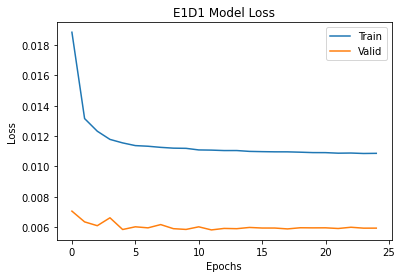

In [103]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

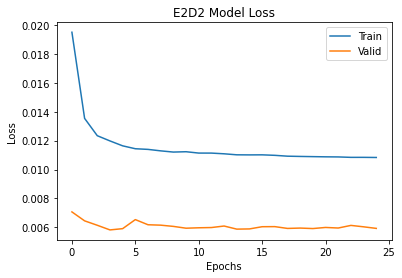

In [104]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [99]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [101]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [102]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
  print()
  print()

Active_Power(kW)
Day  1 :
MAE-E1D1 :  1819.7980885274073, MAE-E2D2 :  1821.701579690301
Day  2 :
MAE-E1D1 :  3000.469724334919, MAE-E2D2 :  2947.906442837178
Day  3 :
MAE-E1D1 :  3851.9226473005956, MAE-E2D2 :  3786.2133300139217
Day  4 :
MAE-E1D1 :  4508.372776533783, MAE-E2D2 :  4436.475819833487
Day  5 :
MAE-E1D1 :  5101.019688006928, MAE-E2D2 :  5029.876678183465


